<font color=black size=4 face=雅黑>**Front Matter**</font>

<font color=steel size=5 face=雅黑></font>
Module : CASA0013 Introduction to Programming for Spatial Analysts 

Name : Jiaqi Qian

ID  : 20134533

Title : Research on the distribution and pricing of Airbnb houses based on the number of crimes in London

Count ：1387

<font color=black size=4 face=雅黑>**Executive Summary**</font>

<font color=steel size=5 face=雅黑></font>
This experiment collected data on Airbnb in December 2020, as well as crime rate data in London from December 2018 to November 2020. The crime rate data was cleaned up, statistics were made according to the area, and the statistical results were visualized. Clean up the Airbnb data, count the house data in each district, and visualize it according to the coordinates. The statistics have sorted out the pricing of different room types. After normalizing the pricing, the K-Means cluster analysis method is used to divide the prices into different levels and visualize the results.

<font color=black size=4 face=雅黑>**Reproducible Analysis**</font>

<font color=black size=4 face=雅黑>**Part1 Visualization of crime rate and house distribution**</font>




In [140]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt

def plt_ldn(w, b):
    fig, ax = plt.subplots(1, figsize=(14, 12))
    w.plot(ax=ax, color='#79aef5', zorder=2)
    b.plot(ax=ax, edgecolor='#cc2d2d', facecolor='None', zorder=3)
    ax.set_xlim([502000,563000])
    ax.set_ylim([155000,201500])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    return fig, ax

<AxesSubplot:>

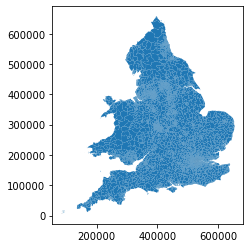

In [2]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
msoas.plot()

In [3]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
w_path = os.path.join('Water.gpkg')
if not os.path.exists(w_path):
    water = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Water.gpkg?raw=true')
    water.to_file(w_path)
    print("Downloaded Water.gpkg file.")
else:
    water = gpd.read_file(w_path)

# Boroughs GeoPackage
b_path = os.path.join('Boroughs.gpkg')
if not os.path.exists(b_path):
    boroughs = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')
    boroughs.to_file(b_path)
    print("Downloaded Boroughs.gpkg file.")
else:
    boroughs = gpd.read_file(b_path)

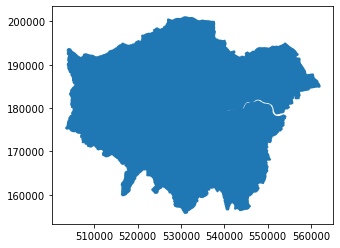

In [4]:
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})
ldn['geometry'] = ldn.original.buffer(250)
ldn = ldn.set_geometry('geometry')
ldn.plot();

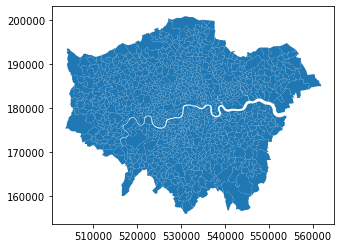

In [5]:
ldn_msoas = gpd.sjoin(msoas, ldn, op='within')
ldn_msoas.plot();

In [6]:
ldn_msoas['Borough'] = ldn_msoas.MSOA11NM.str.replace(r' \d+$','',regex=True)

In [7]:
msoa_nms = pd.read_csv('https://github.com/jreades/i2p/blob/master/data/src/MSOA-Names-1.8.csv.gz?raw=true', compression='gzip')

In [8]:
msoas = pd.merge(ldn_msoas, msoa_nms, left_on='MSOA11CD', right_on='msoa11cd', how='inner')

In [9]:
to_drop = ['MSOA11NMW','LONG','LAT','Shape__Are','Shape__Len','index_right',
           'original','msoa11cd','msoa11nm','msoa11nmw','Laname','msoa11hclnmw']
msoas.drop(columns=to_drop, inplace=True)

In [11]:
msoas.to_file(os.path.join('London_MSOAs.gpkg'), driver='GPKG')

In [110]:
cri=pd.read_csv('cri.csv',
                 usecols=['LookUp_BoroughName','201812','201901','201902','201903','201904','201905','201906','201907','201908','201909','201910','201911','201912','202001','202002','202003','202004','202005','202006','202007','202008','202009','202010','202011'])

In [111]:
cri1= cri.groupby('LookUp_BoroughName').sum()

In [112]:
cri1['sum']=cri1['201812']+cri1['201901']+cri1['201902']+cri1['201903']+cri1['201904']+cri1['201905']+cri1['201906']+cri1['201907']+cri1['201908']+cri1['201909']+cri1['201910']+cri1['201911']+cri1['201912']+cri1['202001']+cri1['202002']+cri1['202003']+cri1['202004']+cri1['202005']+cri1['202006']+cri1['202007']+cri1['202008']+cri1['202009']+cri1['202010']+cri1['202011']

In [113]:
cri1.drop(columns=['201812','201901','201902','201903','201904','201905','201906','201907','201908','201909','201910','201911','201912','202001','202002','202003','202004','202005','202006','202007','202008','202009','202010','202011'], inplace=True)

In [114]:
add = pd.merge(boros, cri1, left_on='NAME', right_index=True).set_index('NAME')

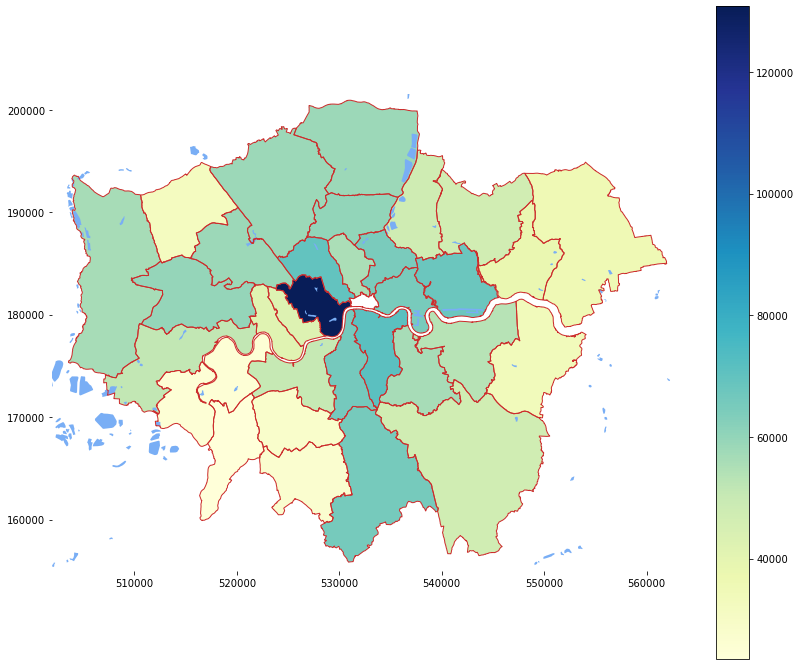

In [125]:
fig, ax = plt_ldn(water, boroughs)
figure=add.plot(column='sum', ax=ax,cmap='YlGnBu',linewidth=0, zorder=0,   legend=True)

In [129]:
cols = ['id','price','latitude','longitude','room_type']
df = pd.read_csv(os.path.join('listings.csv'), usecols=cols, low_memory=False)

In [130]:
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


(76984, 5)


In [131]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

In [132]:
gdf_la = gpd.sjoin(gdf, boros, op='within', how='left')

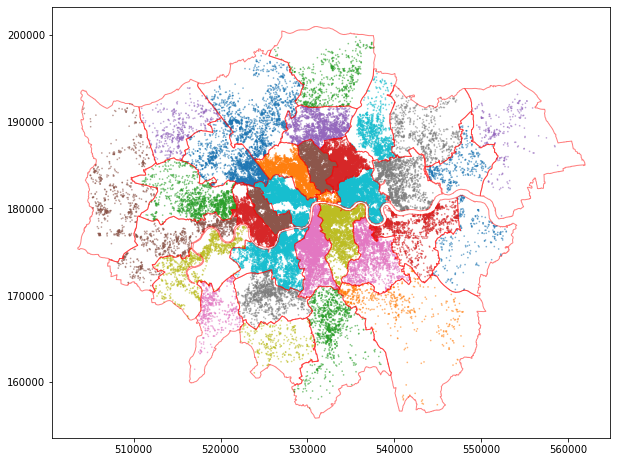

In [133]:
gdf_la.drop(index=gdf[gdf_la.NAME.isna()].index, axis=1, inplace=True)
ax = gdf_la.plot(column='NAME', markersize=0.5, alpha=0.5, figsize=(10,8))
boros.plot(ax=ax, edgecolor='r', facecolor='None', alpha=0.5);

<font color=black size=4 face=雅黑>**Part2 Correlation analysis**</font>

In [134]:
gro =gdf_la.groupby(['NAME'])['room_type'].agg(Count='count').reset_index() # msoa listings grouped counts

                      NAME  Count
0     Barking and Dagenham    405
1                   Barnet   1643
2                   Bexley    273
3                    Brent   2338
4                  Bromley    579
5                   Camden   5258
6           City of London    448
7                  Croydon   1109
8                   Ealing   1673
9                  Enfield    685
10               Greenwich   1583
11                 Hackney   5721
12  Hammersmith and Fulham   3574
13                Haringey   2120
14                  Harrow    451
15                Havering    253
16              Hillingdon    627
17                Hounslow   1034
18               Islington   4489
19  Kensington and Chelsea   5329
20    Kingston upon Thames    511
21                 Lambeth   4406
22                Lewisham   2174
23                  Merton   1249
24                  Newham   1855
25               Redbridge    692
26    Richmond upon Thames   1134
27               Southwark   4330
28            

In [135]:
cor= pd.merge(gro, cri1, left_on='NAME', right_index=True).set_index('NAME')

In [139]:
import numpy
import scipy
x=cor['Count']
y=cor['sum']
scipy.stats.pearsonr(x, y)

(0.694465911039257, 1.037351973215121e-05)

<font color=black size=4 face=雅黑>**Part3 Clustering analysis**</font>

In [142]:
import matplotlib.cm as cm
import matplotlib as mpl
import re
import os

from matplotlib.colors import ListedColormap

# All of these are potentially useful, though
# not all have been used in this practical --
# I'd suggest exploring the use of different 
# Scalers/Transformers as well as clustering 
# algorithms...
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from esda.adbscan import ADBSCAN

import random
random.seed(42)    # For reproducibility
np.random.seed(42) # For reproducibility

# Make numeric display a bit neater
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

rbs = RobustScaler(quantile_range=[0.025,0.975])
mms = MinMaxScaler(feature_range=(-1,1))
pts = PowerTransformer()

def default_cmap(n, outliers=False):
    cmap = mpl.cm.get_cmap('viridis_r', n)
    colors = cmap(np.linspace(0,1,n))
    if outliers:
        gray = np.array([225/256, 225/256, 225/256, 1])
        colors = np.insert(colors, 0, gray, axis=0)
    return ListedColormap(colors)

# mappable = ax.collections[-1] if you add the geopandas
# plot last.
def add_colorbar(mappable, ax, cmap, norm, breaks, outliers=False):
    cb = fig.colorbar(mappable, ax=ax, cmap=cmap, norm=norm,
                    boundaries=breaks,
                    extend=('min' if outliers else 'neither'), 
                    spacing='uniform',
                    orientation='horizontal',
                    fraction=0.05, shrink=0.5, pad=0.05)
    cb.set_label("Cluster Number")

In [143]:
msoas = gpd.read_file(os.path.join('London_MSOAs.gpkg'), driver='GPKG')
msoas = msoas.drop(columns=['OBJECTID','MSOA11NM','BNG_E','BNG_N','Borough','msoa11hclnm'])

In [144]:
df = pd.read_csv('listings.csv', 
                 usecols=['room_type','longitude','latitude','price'])

In [145]:
gdf = gpd.GeoDataFrame(df, 
      geometry=gpd.points_from_xy(df['longitude'], df['latitude'], crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

In [162]:
ml = gpd.sjoin(gdf, msoas, op='within').drop(columns=
    ['latitude','longitude','index_right']
)

In [164]:
ml['price'] = ml.price.str.replace('$','').str.replace(',','').astype(float)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [166]:
mlgc = ml.groupby(['MSOA11CD','room_type'])['price'].agg(Count='count').reset_index() # msoa listings grouped counts
mlgp = ml.groupby('MSOA11CD')['price'].agg('median').reset_index() # msoa listings grouped price

In [167]:
mlgc = mlgc.pivot(index='MSOA11CD', columns=['room_type'], values=['Count']).reset_index()
mlgc.columns = ['MSOA11CD','Entire home/apt','Hotel room','Private room','Shared room']
mlgc.drop(columns=['Hotel room','Shared room'], inplace=True)

In [168]:
mlg = pd.merge(mlgc, mlgp, on='MSOA11CD')
mlg = mlg.fillna(0).set_index('MSOA11CD')

In [170]:
for c in mlg.columns.values:
    mlg[c] = pts.fit_transform(mlg[c].values.reshape(-1,1))
mlgup=mlg.drop(columns=['Entire home/apt','Private room'])

In [171]:
c_nm   = 'KMeans' # Clustering name
k_pref = 3 # Number of clusters

kmeans = KMeans(n_clusters=k_pref, n_init=10, random_state=42).fit(mlgup) # The process

print(kmeans.labels_) # The results

[2 1 1 1 0 0 2 2 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 2 1 1 2 2 0 1 0 1 0 1 0 0 0 2 2 0 0 0 0 0 2 0 0 0 2 0 0 1 1 1 1 1 1 1 1 2
 2 1 1 1 2 1 0 2 1 2 2 0 1 2 0 0 1 2 0 1 0 0 0 0 1 1 2 0 1 1 0 0 2 0 0 2 1
 0 2 1 0 1 0 2 0 2 0 2 0 2 0 1 0 0 0 0 0 2 0 0 0 1 1 0 0 1 1 2 0 0 0 0 1 1
 1 2 1 0 0 1 2 1 1 2 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 2 1 0 0 1 1 1 2 1 1 1 0 1 1 0 1
 0 0 1 2 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0
 1 0 0 0 2 0 1 2 2 1 1 1 1 0 0 1 0 0 1 0 1 0 1 2 0 0 1 0 0 1 0 0 2 2 1 0 0
 0 0 1 0 0 0 0 1 0 0 2 1 0 1 1 1 0 1 2 0 2 0 0 0 2 0 1 1 2 0 1 1 1 0 0 0 0
 0 0 0 0 2 0 0 2 1 0 0 0 2 0 0 2 2 0 2 0 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2
 2 0 2 2 2 2 2 2 2 2 2 2 1 2 1 1 0 1 2 1 0 1 0 2 1 1 0 1 0 2 0 0 1 1 1 1 0
 2 1 0 0 1 2 2 2 2 2 0 1 0 1 1 1 1 2 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 2 1 2
 0 2 0 1 0 0 2 0 1 2 2 1 2 1 2 2 1 2 0 2 0 0 1 2 1 1 0 1 0 0 0 0 0 0 1 1 0
 1 1 1 0 1 1 0 0 0 1 1 1 

In [172]:
mlgup[c_nm] = pd.Series(kmeans.labels_, index=mlg.index)

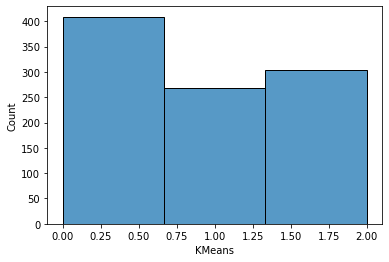

In [173]:
ax = sns.histplot(data=mlgup, x=c_nm, bins=k_pref)

/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/sds2020/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


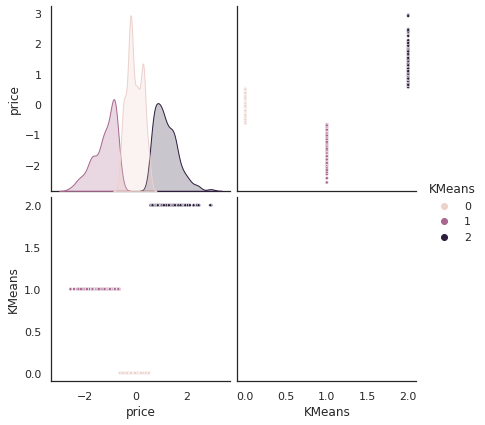

In [174]:
sns.set(style="white")
sns.pairplot(mlgup, 
             vars=mlgup, 
             hue=c_nm, markers=".", height=3, diag_kind='kde');

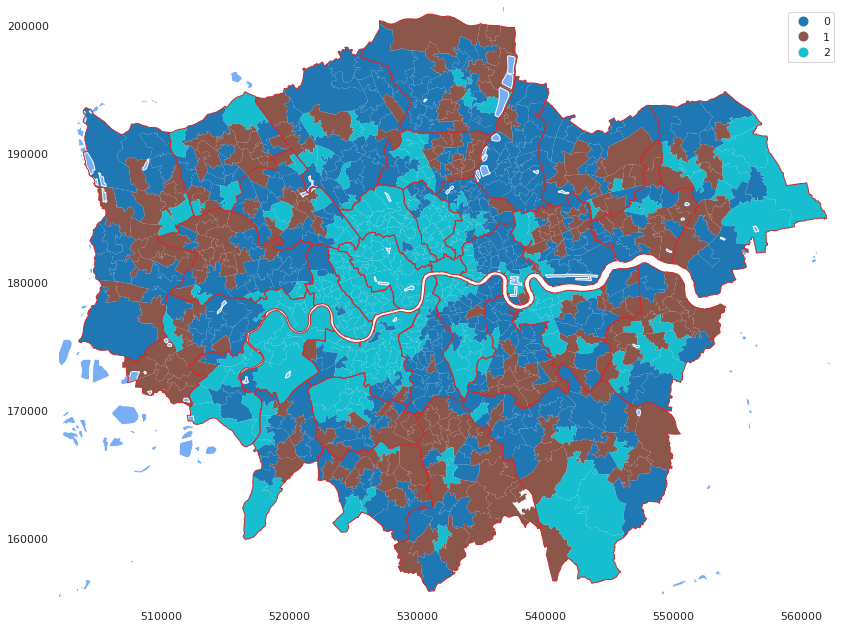

In [175]:
add = pd.merge(msoas,mlgup,left_on='MSOA11CD', right_index=True).set_index('MSOA11CD')
fig, ax = plt_ldn(water, boroughs)
add.plot(column='KMeans', ax=ax, linewidth=0, zorder=0, categorical=True,legend=True);

<font color=black size=4 face=雅黑>**Executive Briefing**</font>

<font color=black size=5 face=雅黑>**Summary**</font>

In recent years, the "sharing economy" has developed rapidly. "Sharing economy" refers to a group of companies that use the Internet as the main interface with consumers when selling or leasing services(AP,2019). Human life is more convenient and faster because of the "sharing economy". Among them, Airbnb, which uses "shared houses" as its main selling point, has developed rapidly and gradually expanded in scale. Airbnb was established in San Francisco in 2007 as an online shared short-term rental service platform for landlords to rent idle houses for short-term rentals. It originated from the idea of 2 college students renting out the air mattresses in the apartment(Guttentag D,2013). So far, the company has more than 7 million units in more than 100,000 cities around the world, and its scale and coverage can reach Comparable to global hotel chains such as Hilton and Marriott(Zervas G et al.2017)

From the consumer's point of view, Airbnb provides convenience for people's journey, and people have more housing options. From a business perspective, Airbnb has re-used some idle houses and made the market more diversified.
While Airbnb is rapidly occupying the market and developing rapidly, some of the following issues also need to be considered. The most important issue is consumer safety.

As the capital of the United Kingdom, London has relatively good social security and the crime rate is relatively low in the country. In 2016, there were 1,330 crime incidents, and in 2017, 1,243 crime incidents occurred. A total of 1401 crime incidents occurred in 2018, an average of 1,325 incidents per year, 110 incidents per month, and 4 incidents per day(He Wei,2020).
This article selects London’s crime rate as the main consideration, combined with a London Airbnb data in December 2020, mainly analyzes two issues: ①crime rate and Airbnb housing location issues ②crime rate and housing pricing issues. The conclusions obtained can provide references for formulating relevant policies.

<font color=black size=5 face=雅黑>**Overview of criminal cases**</font>

This study collected crime data in all districts of London (except City of London) from December 2018 to January 2020. And the various crime cases are summarized by region, and finally drawn into the following figure. As can be seen from the figure, as the color gradually darkens, the number of crime cases is increasing. The overall trend of crimes basically shows a gradual decrease from the center to the outside. Among them, the highest crime rate is Westminster. It is close to the central city of London and is also an important business district in London, so the crime rate is extremely high. Croydon in the south, Hackney in the east, and Lewisham in the southeast are all areas where people of all kinds live together, with relatively poor security and more riots.( BUTLER T,2010)
 
<img style="float:center;" src="crime.jpg" width = "65%">

<font color=black size=5 face=雅黑>**Housing distribution**</font>

Next, we analyzed the distribution of Airbnb's houses, and finally drawn the following figure. In the figure below, each dot represents a house in Airbnb, and the dots in the same area have the same color. Therefore, through the depth of color, you can intuitively see how dense the houses are. As can be seen from the figure, Airbnb houses are mainly concentrated in the center of London, and the number gradually decreases from the center to the surroundings. Due to the convenient transportation, prosperous commerce and many scenic spots in the central city, the houses here are denser, which provides great convenience for tourists.

<img style="float:center;" src="house.jpg" width = "65%">

Next, we counted the total number of crimes and the total number of Airbnb houses according to different regions, and calculated the Pearson Correlation Coefficient of the two. The results obtained are shown in the following table. It can be seen from the table that the Pearson Correlation Coefficient of the two variables is about 0.7, p-value<0.01, and the significance test with a confidence level of 1% is passed. This shows that there is a positive correlation between the number of Airbnb houses and the number of crimes, that is, where there are more crimes, there are also more houses.

<img style="float:center;" src="correlation.jpg" width = "50%">
 

<font color=black size=5 face=雅黑>**housing price**</font>

Next, we analyzed the prices of Airbnb room types. This study uses K-means cluster analysis. First classify the houses according to the room type, calculate the median price of each room type, and then normalize the results obtained. Then we use the K-means algorithm to divide the price into three levels for cluster analysis. The results obtained are shown in the figure below. The color in the figure from dark to light means that the price is gradually increasing. As can be seen from the figure, the areas with the highest prices are mostly concentrated in central London and the southwest area. The central area has higher prices due to its geographical advantages. The Southwest is one of London’s wealthy areas, so housing prices here are also higher(HAMNETT C , WUITELEGG A,2007). In addition, it can be seen from the figure that Airbnb's house prices are mostly mid-level, while high-end and low-end house prices exist, but few. Such housing prices are in line with people's consumption needs.

<img style="float:center;" src="price.jpg" width = "65%">
 
Comparing the cluster distribution map of housing prices and the distribution map of the number of crimes, it is not difficult to get the following conclusions. Central London is strategically located and has a large passenger flow. The price here is mainly affected by geographical location, so it is higher. The traffic here is dense, leading to a high crime rate. The rest of the areas with higher prices are not the first choice for tourists, and most of them are local rich areas in London. The security in these areas is also good, so the crime rate is very low. The areas with lower housing prices basically coincide with areas with higher crime rates. Due to local cultural and ethnic factors, the security in these areas is not good, which affects the location and pricing of Airbnb in these areas.

<font color=black size=5 face=雅黑>**Conclusion**</font>

Based on the above analysis, the following conclusions can be drawn:

The crime rate in London as a whole shows a decreasing trend from the middle to the surroundings. Most of the crimes are concentrated in the central business districts, as well as several areas that have been heavily influenced by ethnicity and culture.

1. The distribution of Airbnb's houses in London also shows a denser central part and sparse surroundings. This is affected by the geographical location and cultural environment of the central region. In addition, transportation is also an important determinant.

2. The distribution of Airbnb houses and the crime rate are positively correlated. The more concentrated the houses, the denser the population, so there are more crimes.

3. Airbnb's prices are relatively reasonable, mostly at mid-range. Housing prices in the central region are relatively high, and prices tend to decrease towards the surrounding areas.

<font color=black size=5 face=雅黑>**Suggesstion**</font>

First of all, the most important thing is the governance of criminal situations. It can be seen from the analysis that the crime situation in central London is significantly higher than in other areas. Therefore, in the central city, public security management should be strengthened. This area is also London's main business district and tourist area. If the crime situation in this area can be effectively managed, it will also help enhance the overall image of London.
Second, we can see that there is a positive correlation between the crime rate and the density of Airbnb housing distribution. This reminds Airbnb to pay attention to the safety of consumers. Airbnb should be in different areas, according to the size of the crime rate, to give consumers certain tips. In addition, when it is clear that the crime rate is different, Airbnb should also actively negotiate with the government and adopt a district-based governance model. For different areas, different levels of security should be set.

In addition, Airbnb's price setting is more reasonable. The surrounding security issues should also be considered in the subsequent site selection and pricing. The areas with higher prices are mainly concentrated in the central area and are more concentrated. But areas with lower prices are more scattered. Therefore, Airbnb should study the common characteristics of these areas and find out whether the reason for the low pricing is environmental or housing problems.  Only by choosing the right method, Airbnb in London can develop more prosperously and provide consumers with greater convenience.

<font color=black size=5 face=雅黑>**Appendix**</font>

<font color=black size=5 face=雅黑>**Reference**</font>

Associated Press (AP). 2019. “Question from Washington on Oct. 11, 2016” (search result for “sharing economy”). AP Stylebook subscription-based website, accessed January 4, 2019.

Guttentag D. Airbnb: Disruptive innovation and the rise of an informal tourism accommodation sector [J]. Current Issues in Tourism, 2013, 18(12): 1192-1217.

Zervas G, Proserpio D, Byers J W. The rise of the sharing economy: Estimating the impact of Airbnb on the hotel industry [J]. Journal of Marketing Research, 2017, 54(5): 687-705.

He Wei .Visual Analysis of Police Data. Journal of Fujian Computer,2020,36(6)

HAMNETT C , WUITELEGG A . From industrial to post industrial land uses: The loft conversion market in London[J].Environment an Planning A,2007,39(1):106-124

BUTLER T．The changing Ethnic structure of housing tenures in London 1991-2001[J].Urban Studies,2010,47(1):55-74
